In [1]:
import re
import os
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.formula.api as smf

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df_continents = pd.read_csv(os.path.join("Data", "continents.csv"))

display(df_continents)

,article,continent
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Europe
1,%C3%85land,Europe
2,%C3%89douard_Manet,Europe
3,%C3%89ire,Europe
4,%C3%93engus_I_of_the_Picts,Europe
...,...,...
4599,Zionism,Asia
4600,Zirconium,International
4601,Zoroaster,Asia
4602,Zuid-Gelders,Europe


### Colors for all plots

In [4]:
continents = df_continents['continent'].unique()
random_colors = sns.color_palette('husl', n_colors=len(continents))
continents_colors = {}
continents_colors_int = {}
for i in range(len(continents)):
    continents_colors[continents[i]] = random_colors[i]
    continents_colors_int[continents[i]] = tuple(map(lambda x: int(255 * x), random_colors[i]))
    continents_colors_int[continents[i]] = "#{0:02x}{1:02x}{2:02x}".format(*continents_colors_int[continents[i]])
print(continents_colors)
print(continents_colors_int)


{'Europe': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'International': (0.8087954113106306, 0.5634700050056693, 0.19502642696727285), 'North America': (0.5920891529639701, 0.6418467016378244, 0.1935069134991043), 'Australia': (0.19783576093349015, 0.6955516966063037, 0.3995301037444499), 'Asia': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), 'Africa': (0.22335772267769388, 0.6565792317435265, 0.8171355503265633), 'South America': (0.6423044349219739, 0.5497680051256467, 0.9582651433656727), 'Antarctica': (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)}
{'Europe': '#f67088', 'International': '#ce8f31', 'North America': '#96a331', 'Australia': '#32b165', 'Asia': '#35aca4', 'Africa': '#38a7d0', 'South America': '#a38cf4', 'Antarctica': '#f461dd'}


### Articles per continent

In [5]:
continents_grouped = df_continents.groupby(['continent']).size()
continents_grouped = continents_grouped.sort_values(ascending=False)
continents_grouped

continent
International    1870
Europe           1245
North America     593
Asia              377
Africa            265
South America     123
Australia         122
Antarctica          9
dtype: int64

Text(0.5, 1.0, 'Count of Categories by Continent')

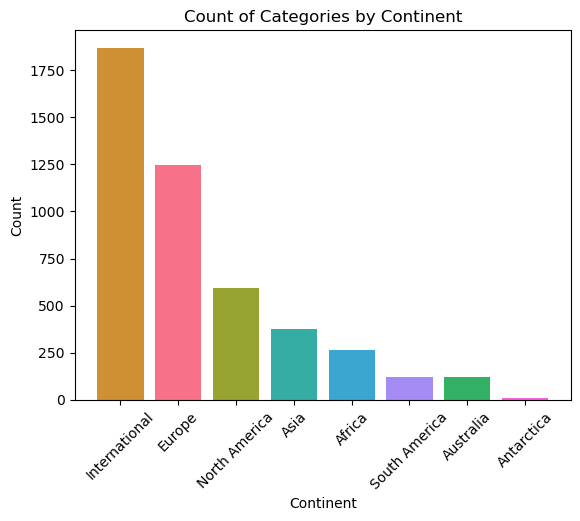

In [6]:
num_categories = len(continents_grouped.keys())
ax = plt.bar(continents_grouped.keys(), continents_grouped.values, color=[continents_colors[continent] for continent in continents_grouped.keys()])
plt.xticks(rotation=45)

fig = px.bar(
    x=list(continents_grouped.keys()),
    y=list(continents_grouped.values),
    labels={"x": "Continent", "y": "Count"},
    title="Count of Categories by Continent",
    color=list(continents_grouped.keys()),
)

# fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(showlegend=False)

file_path = os.path.join(plots_path, "count_of_categories_by_continent.html")
fig.write_html(file_path)

fig.show()


In [7]:
plots_path = "plots"
os.makedirs(plots_path, exist_ok=True)

fig = px.bar(
    x=list(continents_grouped.keys()),
    y=list(continents_grouped.values),
    labels={"x": "Continent", "y": "Count"},
    title="Count of Categories by Continent",
    color=[continents_colors_int[continent] for continent in continents_grouped.index],
    color_discrete_map="identity"
)

# fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(showlegend=False)

file_path = os.path.join(plots_path, "count_of_categories_by_continent.html")
fig.write_html(file_path)

fig.show()

## Number of articles by category

In [8]:
df_categories = pd.read_csv(
    os.path.join("Data", "wikispeedia_paths-and-graph", "categories.tsv"),
    delimiter="\t",
    header=None,
    names=["article", "category"],
    skip_blank_lines=True,
    comment="#",
    encoding="UTF-8"
)

display(df_categories.head())
print("Size:", df_categories.shape)

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


Size: (5204, 2)


In [9]:
df_articles = pd.merge(df_categories, df_continents, on="article", how="left")
display(df_articles.head())
print("Size:", df_articles.shape, "Missing values:", df_articles.isna().any().any())

,article,category,continent
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...,Europe
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures,Europe
2,%C3%85land,subject.Countries,Europe
3,%C3%85land,subject.Geography.European_Geography.European_...,Europe
4,%C3%89douard_Manet,subject.People.Artists,Europe


Size: (5204, 3) Missing values: False


In [10]:
main_cats = []
for category in df_articles['category'].values:
    main_cats.append(category.split('.')[1])

df_articles['categoryMain'] = main_cats
display(df_articles)
print("Size:", df_articles.shape)

,article,category,continent,categoryMain
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...,Europe,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures,Europe,People
2,%C3%85land,subject.Countries,Europe,Countries
3,%C3%85land,subject.Geography.European_Geography.European_...,Europe,Geography
4,%C3%89douard_Manet,subject.People.Artists,Europe,People
...,...,...,...,...
5199,Zirconium,subject.Science.Chemistry.Chemical_elements,International,Science
5200,Zoroaster,subject.People.Religious_figures_and_leaders,Asia,People
5201,Zuid-Gelders,subject.Geography.European_Geography,Europe,Geography
5202,Zuid-Gelders,subject.Language_and_literature.Languages,Europe,Language_and_literature


Size: (5204, 4)


In [11]:
articles_cat_continent = df_articles.groupby(['categoryMain', 'continent']).size()
display(articles_cat_continent[('Geography', 'International')])

163

In [12]:
display(articles_cat_continent)

categoryMain      continent    
Art               Asia               1
                  Europe            13
                  International     24
Business_Studies  Africa             1
                  Asia               6
                                  ... 
Science           Australia         25
                  Europe            33
                  International    944
                  North America     28
                  South America     11
Length: 88, dtype: int64

,History,People,Countries,Geography,Business_Studies,Science,Everyday_life,Design_and_Technology,Music,IT,Language_and_literature,Mathematics,Religion,Art,Citizenship
Africa,30,17,52,143,1,61,2,4,2,0,9,0,1,0,4
Antarctica,0,0,0,7,0,3,0,0,0,0,0,0,0,0,0
Asia,53,51,55,169,6,17,19,11,3,0,14,1,29,1,15
Australia,10,12,15,64,0,25,5,3,2,0,1,0,1,0,1
Europe,313,415,55,287,17,33,51,71,33,2,101,0,41,13,33
North America,53,183,4,166,7,28,51,59,18,4,15,0,5,0,26
South America,9,9,48,85,0,11,0,1,10,0,0,0,0,0,1


Size: (7, 15)


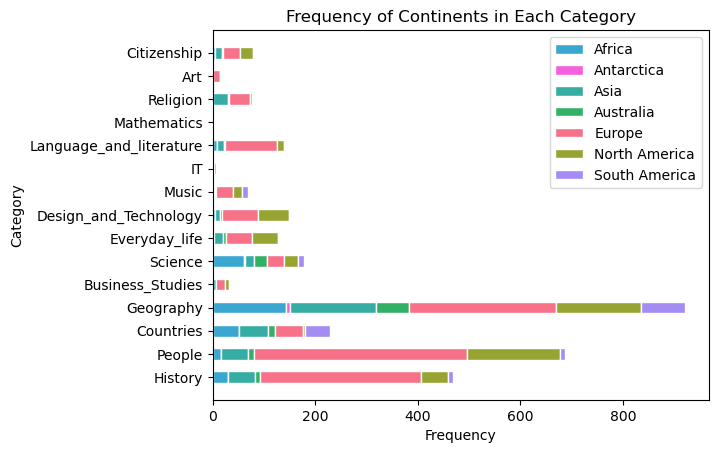

In [13]:
categories = df_articles['categoryMain'].unique()
continents = df_articles['continent'].unique()
continents.sort()

#In case we do not want international
mask = (continents != 'International')
continents = continents[mask]

category_positions = np.arange(len(categories))
bar_width = 0.5

continents_values = {}
for i, continent in enumerate(continents):
    frequencies = []
    for category in categories:
        try:
            value = articles_cat_continent[(category, continent)]
        except KeyError:
            value = 0
        frequencies.append(value)
    continents_values[continent] = frequencies

df_continent_frequencies = pd.DataFrame(continents_values).T
df_continent_frequencies.columns = categories
display(df_continent_frequencies)
print("Size:", df_continent_frequencies.shape)

fig = px.bar(
    df_continent_frequencies.T,
    orientation='h',
    title='Frequency of Continents in Each Category',
    labels={"index": "Category", "value": "Frequency"},
    #category_orders={"index": categories},
)

file_path = os.path.join(plots_path, "frequency_continents_in_each_category.html")
fig.write_html(file_path)

for continent in continents:
    ax.barh(categories, continents_values[continent], label=continent, color=continents_colors[continent], edgecolor='w', height=0.5, left=bottom)
    bottom += continents_values[continent]

ax.set_yticks(category_positions)
ax.set_yticklabels(categories)
ax.set_xlabel('Frequency')
ax.set_ylabel('Category')
plt.title('Frequency of Continents in Each Category')
plt.legend()

plt.show()


In [14]:
continent_sorted = df_continent_frequencies.sum(axis="columns").sort_values(ascending=False).index

fig = px.bar(
    df_continent_frequencies.loc[continent_sorted].T.loc[df_continent_frequencies.sum(axis="index").sort_values().index],
    orientation ='h',
    title='Frequency of Continents in Each Category',
    labels={"index": "Category", "value": "Frequency"},
    color_discrete_sequence=[continents_colors_int[continent] for continent in continent_sorted],
)

file_path = os.path.join(plots_path, "frequency_continents_in_each_category.html")
fig.write_html(file_path)

fig.show()

In [15]:
category_counts = df_articles["categoryMain"].value_counts()

display(category_counts)

df_articles["categoryCounts"] = df_articles["categoryMain"].replace(category_counts)
df_articles = df_articles.sort_values("categoryCounts", ascending=False).drop_duplicates("article")

display(df_articles)


Science                    1122
Geography                  1084
People                      689
History                     545
Everyday_life               374
Design_and_Technology       254
Countries                   229
Citizenship                 224
Language_and_literature     196
Religion                    134
Music                        97
Business_Studies             88
IT                           85
Mathematics                  45
Art                          38
Name: categoryMain, dtype: int64

,article,category,continent,categoryMain,categoryCounts
3082,Meitnerium,subject.Science.Chemistry.Chemical_elements,International,Science,1122
3665,Pigeon,subject.Science.Biology.Birds,International,Science,1122
1029,Chromatophore,subject.Science.Biology.General_Biology,International,Science,1122
1028,Chromatic_aberration,subject.Science.Physics.Space_Astronomy,International,Science,1122
3668,Pinworm,subject.Science.Biology.Health_and_medicine,International,Science,1122
...,...,...,...,...,...
1636,Expressionism,subject.Art.Art,International,Art,38
3357,Niccol%C3%B2_dell%27Abbate,subject.Art.Artists,Europe,Art,38
108,Abstract_art,subject.Art.Art,International,Art,38
4356,Stained_glass,subject.Art.Art,International,Art,38


## Length of articles

In [16]:
all_articles = pd.read_csv(
    os.path.join("Data", "wikispeedia_paths-and-graph", "articles.tsv"),
    sep="\t",
    header=None,
    names=["article"],
    skip_blank_lines=True,
    comment="#",
).article.tolist()

print("Number of articles:", len(all_articles))
print("Articles without category:")

invalid_articles = set(all_articles) - set(df_articles.article)
for article in invalid_articles:
    print(article)

Number of articles: 4604
Articles without category:
Pikachu
Donation
Friend_Directdebit
Directdebit
Sponsorship_Directdebit
Wowpurchase


In [17]:
plaintext_path = os.path.join('Data', 'plaintext_articles')

word_counts = []
for article_name in df_articles.article:
    file_path = os.path.join(plaintext_path, article_name + '.txt')

    with open(file_path, 'r', encoding='utf-8') as file:

        _ = file.readline() # Skip the first line because it contains the word #copyright
        content = file.read()

    content = content[:re.search("Retrieved from", content).start(0)]
    word_count = len(content.split())

    word_counts.append(word_count)

df_articles['length'] = word_counts

display(df_articles.head())
print("Size:", df_articles.shape)

,article,category,continent,categoryMain,categoryCounts,length
3082,Meitnerium,subject.Science.Chemistry.Chemical_elements,International,Science,1122,252
3665,Pigeon,subject.Science.Biology.Birds,International,Science,1122,3790
1029,Chromatophore,subject.Science.Biology.General_Biology,International,Science,1122,2632
1028,Chromatic_aberration,subject.Science.Physics.Space_Astronomy,International,Science,1122,857
3668,Pinworm,subject.Science.Biology.Health_and_medicine,International,Science,1122,635


Size: (4598, 6)


In [18]:
continent_length = df_articles.groupby(['continent']).length.agg(scipy.stats.gmean)
continent_length = continent_length.sort_values(ascending=False)

display(continent_length)
print("Size:", continent_length.shape)

continent
North America    3016.458447
Asia             2957.833657
Europe           2773.623888
Australia        2063.341870
South America    2031.787167
International    1858.597103
Antarctica       1611.262593
Africa           1368.348439
Name: length, dtype: float64

Size: (8,)


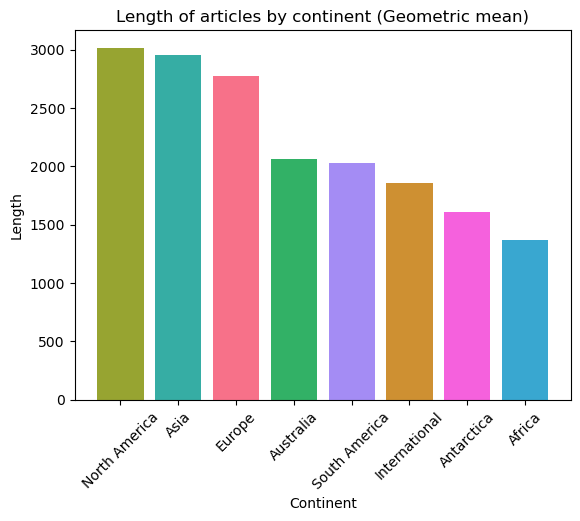

In [19]:
ax = plt.bar(continent_length.index,continent_length.values.reshape(continent_length.shape[0]), color=[continents_colors[continent] for continent in continent_length.index])
plt.xticks(rotation=45)

plt.xlabel('Continent')
plt.ylabel('Length')
plt.title('Length of articles by continent (Geometric mean)')
plt.show()

In [20]:
fig = px.bar(
    x=continent_length.index,
    y=continent_length.values.reshape(continent_length.shape[0]),
    labels={"x": "Continent", "y": "Length"},
    title="Length of articles by continent (Geometric mean)",
    color=[continents_colors_int[continent] for continent in continent_length.index],
    color_discrete_map="identity"
)

fig.update_layout(showlegend=False)

file_path = os.path.join(plots_path, "average_length_of_articles_by_continent.html")
fig.write_html(file_path)

fig.show()

## Pagerank

In [21]:
# Load pagerank
pagerank_df = pd.read_csv(os.path.join("Data", "page_rank.csv"))

In [22]:
display(pagerank_df.head())
print("Size:", pagerank_df.shape)

,article,pageRank
0,United_States,0.014263
1,United_Kingdom,0.007679
2,Scientific_classification,0.007209
3,Europe,0.007043
4,England,0.006815


Size: (4592, 2)


In [23]:
df_articles = pd.merge(df_articles, pagerank_df, on="article", how="left").fillna(1e-6)

display(df_articles.head())
print("Size:", df_articles.shape)

,article,category,continent,categoryMain,categoryCounts,length,pageRank
0,Meitnerium,subject.Science.Chemistry.Chemical_elements,International,Science,1122,252,0.000078
1,Pigeon,subject.Science.Biology.Birds,International,Science,1122,3790,0.000089
2,Chromatophore,subject.Science.Biology.General_Biology,International,Science,1122,2632,0.000053
3,Chromatic_aberration,subject.Science.Physics.Space_Astronomy,International,Science,1122,857,0.000088
4,Pinworm,subject.Science.Biology.Health_and_medicine,International,Science,1122,635,0.000053


Size: (4598, 7)


In [24]:
# Compute mean
pagerank_continent_mean = df_articles.groupby("continent")["pageRank"].agg(scipy.stats.gmean)
pagerank_continent_mean = pagerank_continent_mean.sort_values(ascending=False)

# Compute mean
pagerank_continent_median = df_articles.groupby("continent")["pageRank"].median()
pagerank_continent_median = pagerank_continent_median.sort_values(ascending=False)

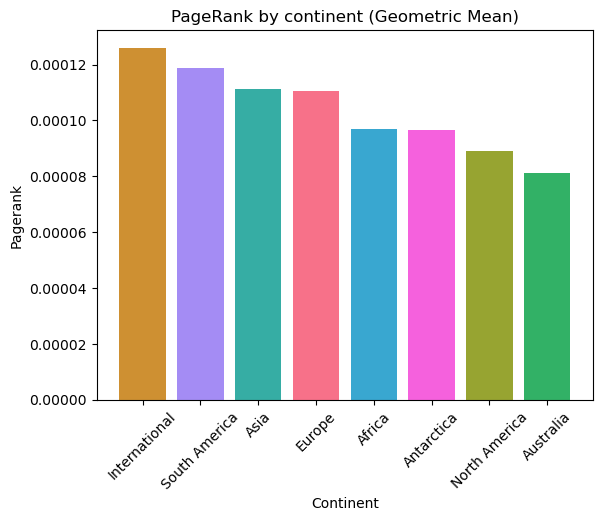

In [25]:
ax = plt.bar(pagerank_continent_mean.index, pagerank_continent_mean, color=[continents_colors[continent] for continent in pagerank_continent_mean.index])
plt.xticks(rotation=45)

plt.xlabel('Continent')
plt.ylabel('Pagerank')
plt.title('PageRank by continent (Geometric Mean)')

plt.show()

In [26]:
pagerank_continent_mean

continent
International    0.000126
South America    0.000119
Asia             0.000111
Europe           0.000111
Africa           0.000097
Antarctica       0.000097
North America    0.000089
Australia        0.000081
Name: pageRank, dtype: float64

In [27]:
fig = px.bar(
    x=pagerank_continent_mean.index,
    y=pagerank_continent_mean,
    labels={"x": "Continent", "y": "PageRank"},
    title="PageRank by continent (Geometric Mean)",
    color=[continents_colors_int[continent] for continent in pagerank_continent_mean.index],
    color_discrete_map="identity"
)

fig.update_layout(showlegend=False)
fig.update_yaxes(tickformat=".1e")

file_path = os.path.join(plots_path, "pagerank_mean_by_continent.html")
fig.write_html(file_path)

fig.show()

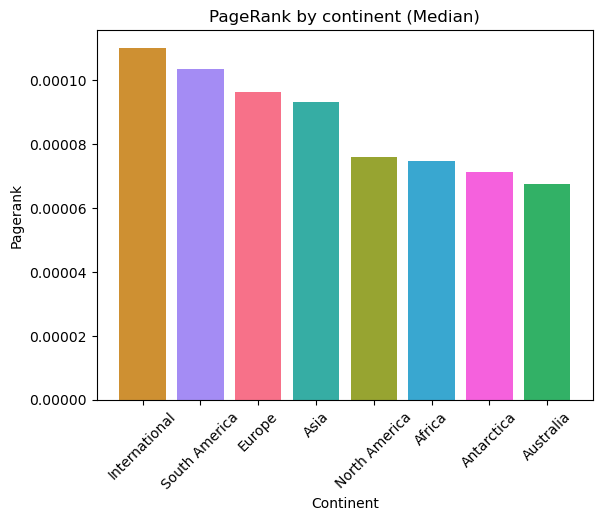

In [28]:
ax = plt.bar(pagerank_continent_median.index, pagerank_continent_median, color=[continents_colors[continent] for continent in pagerank_continent_median.index])
plt.xticks(rotation=45)

plt.xlabel('Continent')
plt.ylabel('Pagerank')
plt.title('PageRank by continent (Median)')

plt.show()

In [29]:
fig = px.bar(
    x=pagerank_continent_median.index,
    y=pagerank_continent_median,
    labels={"x": "Continent", "y": "PageRank"},
    title="PageRank by continent (Median)",
    color=[continents_colors_int[continent] for continent in pagerank_continent_median.index],
    color_discrete_map="identity"
)

fig.update_layout(showlegend=False)
fig.update_yaxes(tickformat=".1e")

file_path = os.path.join(plots_path, "pagerank_median_by_continent.html")
fig.write_html(file_path)

fig.show()

## Analysis of paths

Group paths by continents, one path will be assigned to the continent corresponding to the GOAL article

Compute the number of "backclicks" in each path

Compute the length of each path

In [30]:
df_paths_finished = pd.read_csv(
    os.path.join("Data", "wikispeedia_paths-and-graph", "paths_finished.tsv"),
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    skip_blank_lines=True,
    comment="#"
)
df_paths_unfinished = pd.read_csv(
    os.path.join("Data", "wikispeedia_paths-and-graph", "paths_unfinished.tsv"),
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "motif"],
    skip_blank_lines=True,
    comment="#"
)

df_paths_finished['backclicks'] = df_paths_finished['path'].apply(lambda x: x.count('<'))
df_paths_finished['pathSteps'] = df_paths_finished['path'].apply(lambda x: x.count(';') + 1)
df_paths_finished["uniqueArticles"] = df_paths_finished['pathSteps'] - df_paths_finished['backclicks']
df_paths_finished["path"] = df_paths_finished['path'].apply(lambda x: x.split(';'))
df_paths_finished["start"] = df_paths_finished["path"].str[0]
df_paths_finished["target"] = df_paths_finished["path"].str[0]
df_paths_finished["isFinished"] = True

df_paths_unfinished['backclicks'] = df_paths_unfinished['path'].apply(lambda x: x.count('<'))
df_paths_unfinished['pathSteps'] = df_paths_unfinished['path'].apply(lambda x: x.count(';') + 1)
df_paths_unfinished["uniqueArticles"] = df_paths_unfinished['pathSteps'] - df_paths_unfinished['backclicks']
df_paths_unfinished["path"] = df_paths_unfinished['path'].apply(lambda x: x.split(';'))
df_paths_unfinished["start"] = df_paths_unfinished["path"].str[0]
df_paths_unfinished["isFinished"] = False

display(df_paths_finished.head())
display(df_paths_unfinished.head())

df_paths = pd.concat([df_paths_finished, df_paths_unfinished])
display(df_paths.head())

,hashedIpAddress,timestamp,durationInSec,path,rating,backclicks,pathSteps,uniqueArticles,start,target,isFinished
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,0,9,9,14th_century,14th_century,True
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,0,5,5,14th_century,14th_century,True
2,415612e93584d30e,1349298640,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,0,8,8,14th_century,14th_century,True
3,64dd5cd342e3780c,1265613925,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,0,4,4,14th_century,14th_century,True
4,015245d773376aab,1366730828,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,0,7,7,14th_century,14th_century,True


,hashedIpAddress,timestamp,durationInSec,path,target,motif,backclicks,pathSteps,uniqueArticles,start,isFinished
0,2426091a53125110,1297054935,1804,[Obi-Wan_Kenobi],Microsoft,timeout,0,1,1,Obi-Wan_Kenobi,False
1,26141fd878806294,1297055651,1805,[Julius_Caesar],Caracas,timeout,0,1,1,Julius_Caesar,False
2,2b015fb8181c48f2,1297090819,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,0,3,3,Malawi,False
3,53a53bc244e08a6a,1297094761,49,[Paraguay],Mount_St._Helens,restart,0,1,1,Paraguay,False
4,53a53bc244e08a6a,1297099105,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,0,2,2,Paraguay,False


,hashedIpAddress,timestamp,durationInSec,path,rating,backclicks,pathSteps,uniqueArticles,start,target,isFinished,motif
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,0,9,9,14th_century,14th_century,True,NaN
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,0,5,5,14th_century,14th_century,True,NaN
2,415612e93584d30e,1349298640,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,0,8,8,14th_century,14th_century,True,NaN
3,64dd5cd342e3780c,1265613925,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,0,4,4,14th_century,14th_century,True,NaN
4,015245d773376aab,1366730828,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,0,7,7,14th_century,14th_century,True,NaN


In [31]:
"sdasADfds".title()

'Sdasadfds'

In [32]:
tmp = df_articles.copy()
tmp.columns = [column[0].upper() + column[1:] for column in tmp.columns]
tmp = tmp.add_prefix("target")

df_analysis = pd.merge(df_paths, tmp, left_on="target", right_on="targetArticle", suffixes=["", ]).drop(columns="targetArticle")

tmp = df_articles.copy()
tmp.columns = [column[0].upper() + column[1:] for column in tmp.columns]
tmp = tmp.add_prefix("start")
df_analysis = pd.merge(df_analysis, tmp, left_on="start", right_on="startArticle", suffixes=["", ]).drop(columns="startArticle")

display(df_analysis.head())
print("Size:", df_analysis.shape)


,hashedIpAddress,timestamp,durationInSec,path,rating,backclicks,pathSteps,uniqueArticles,start,target,...,targetCategoryMain,targetCategoryCounts,targetLength,targetPageRank,startCategory,startContinent,startCategoryMain,startCategoryCounts,startLength,startPageRank
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,0,9,9,14th_century,14th_century,...,History,545,889,0.000518,subject.History.General_history,International,History,545,889,0.000518
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,0,5,5,14th_century,14th_century,...,History,545,889,0.000518,subject.History.General_history,International,History,545,889,0.000518
2,415612e93584d30e,1349298640,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,0,8,8,14th_century,14th_century,...,History,545,889,0.000518,subject.History.General_history,International,History,545,889,0.000518
3,64dd5cd342e3780c,1265613925,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,0,4,4,14th_century,14th_century,...,History,545,889,0.000518,subject.History.General_history,International,History,545,889,0.000518
4,015245d773376aab,1366730828,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,0,7,7,14th_century,14th_century,...,History,545,889,0.000518,subject.History.General_history,International,History,545,889,0.000518


Size: (76056, 24)


In [33]:
df_analysis["isFinishedInt"] = df_analysis["isFinished"].astype(int)
df_analysis_finished = df_analysis[df_analysis["isFinished"]]
df_analysis_unfinished = df_analysis[~df_analysis["isFinished"]]

df_analysis_per_continent = pd.DataFrame()
for name in ["start", "target"]:
    # Create a column to show the number of articles in each continent
    df_analysis_per_continent[f"{name}Articles"] = df_analysis.groupby(f"{name}Continent").size()

    # Create columns for av. backclicks
    df_analysis_per_continent[f"{name}BackcliksFinished"] =  df_analysis_finished.groupby(f"{name}Continent")["backclicks"].agg(scipy.stats.gmean)
    df_analysis_per_continent[f"{name}BackcliksUnfinished"] =  df_analysis_unfinished.groupby(f"{name}Continent")["backclicks"].agg(scipy.stats.gmean)

    # Create columns for av. path steps
    df_analysis_per_continent[f"{name}PathStepsFinished"] =  df_analysis_finished.groupby(f"{name}Continent")["pathSteps"].agg(scipy.stats.gmean)
    df_analysis_per_continent[f"{name}PathStepsUnfinished"] =  df_analysis_unfinished.groupby(f"{name}Continent")["pathSteps"].agg(scipy.stats.gmean)

    # Create columns for the number of finished and unfinished paths for each continent
    df_analysis_per_continent[f"{name}PathsFinished"] = df_analysis_finished[f"{name}Continent"].value_counts()
    df_analysis_per_continent[f"{name}PathsUnfinished"] = df_analysis_unfinished[f"{name}Continent"].value_counts()
    df_analysis_per_continent[f'{name}PathsFinishedPercentage'] = df_analysis.groupby(f"{name}Continent")["isFinishedInt"].mean() * 100

df_analysis_per_continent.index.name = "continent"

In [34]:
continent_data = df_analysis_per_continent.sort_values(by='targetPathsFinishedPercentage',ascending=False)
display(continent_data)
print("Size:", continent_data.shape)

,startArticles,startBackcliksFinished,startBackcliksUnfinished,startPathStepsFinished,startPathStepsUnfinished,startPathsFinished,startPathsUnfinished,startPathsFinishedPercentage,targetArticles,targetBackcliksFinished,targetBackcliksUnfinished,targetPathStepsFinished,targetPathStepsUnfinished,targetPathsFinished,targetPathsUnfinished,targetPathsFinishedPercentage
continent,,,,,,,,,,,,,,,,
Africa,5026,0.0,0.0,6.095697,3.818847,3085,1941,61.380820,3985,0.0,0.0,6.095697,3.418098,3085,900,77.415307
South America,1715,0.0,0.0,5.880690,3.429645,1183,532,68.979592,1598,0.0,0.0,5.880690,3.345492,1183,415,74.030038
Asia,5330,0.0,0.0,5.821634,3.515940,3746,1584,70.281426,5139,0.0,0.0,5.821634,3.355349,3746,1393,72.893559
Australia,1422,0.0,0.0,5.827701,3.720280,977,445,68.706048,1381,0.0,0.0,5.827701,3.380288,977,404,70.745836
Europe,15581,0.0,0.0,5.952104,3.459271,10674,4907,68.506514,15790,0.0,0.0,5.952104,3.390671,10674,5116,67.599747
International,38473,0.0,0.0,6.093001,3.549979,25788,12685,67.028825,39289,0.0,0.0,6.093001,3.583692,25788,13501,65.636692
North America,8363,0.0,0.0,5.803891,3.519445,5688,2675,68.013871,8697,0.0,0.0,5.803891,3.883048,5688,3009,65.401863
Antarctica,146,0.0,0.0,5.750911,3.548864,113,33,77.397260,177,0.0,0.0,5.750911,2.338658,113,64,63.841808


Size: (8, 16)


In [35]:
continent_data = df_analysis_per_continent.sort_values(by='startPathsFinishedPercentage',ascending=False)
display(continent_data)
print("Size:", continent_data.shape)

,startArticles,startBackcliksFinished,startBackcliksUnfinished,startPathStepsFinished,startPathStepsUnfinished,startPathsFinished,startPathsUnfinished,startPathsFinishedPercentage,targetArticles,targetBackcliksFinished,targetBackcliksUnfinished,targetPathStepsFinished,targetPathStepsUnfinished,targetPathsFinished,targetPathsUnfinished,targetPathsFinishedPercentage
continent,,,,,,,,,,,,,,,,
Antarctica,146,0.0,0.0,5.750911,3.548864,113,33,77.397260,177,0.0,0.0,5.750911,2.338658,113,64,63.841808
Asia,5330,0.0,0.0,5.821634,3.515940,3746,1584,70.281426,5139,0.0,0.0,5.821634,3.355349,3746,1393,72.893559
South America,1715,0.0,0.0,5.880690,3.429645,1183,532,68.979592,1598,0.0,0.0,5.880690,3.345492,1183,415,74.030038
Australia,1422,0.0,0.0,5.827701,3.720280,977,445,68.706048,1381,0.0,0.0,5.827701,3.380288,977,404,70.745836
Europe,15581,0.0,0.0,5.952104,3.459271,10674,4907,68.506514,15790,0.0,0.0,5.952104,3.390671,10674,5116,67.599747
North America,8363,0.0,0.0,5.803891,3.519445,5688,2675,68.013871,8697,0.0,0.0,5.803891,3.883048,5688,3009,65.401863
International,38473,0.0,0.0,6.093001,3.549979,25788,12685,67.028825,39289,0.0,0.0,6.093001,3.583692,25788,13501,65.636692
Africa,5026,0.0,0.0,6.095697,3.818847,3085,1941,61.380820,3985,0.0,0.0,6.095697,3.418098,3085,900,77.415307


Size: (8, 16)


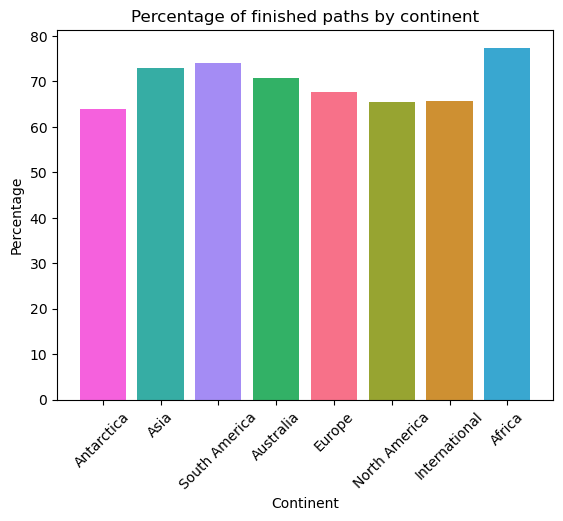

In [36]:
ax = plt.bar(continent_data.index,continent_data['targetPathsFinishedPercentage'], color=[continents_colors[continent] for continent in continent_data.index])
plt.xticks(rotation=45)

plt.xlabel('Continent')
plt.ylabel('Percentage')
plt.title('Percentage of finished paths by continent')
plt.show()

In [37]:
fig = px.bar(
    x=continent_data.index,
    y=continent_data['targetPathsFinishedPercentage'],
    labels={"x": "Continent", "y": "Percentage"},
    title="Percentage of finished paths by continent",
    color=[continents_colors_int[continent] for continent in continent_data.index],
    color_discrete_map="identity"
)

fig.update_layout(showlegend=False)

file_path = os.path.join(plots_path, "percentage_finished_paths_by_continent.html")
fig.write_html(file_path)

fig.show()

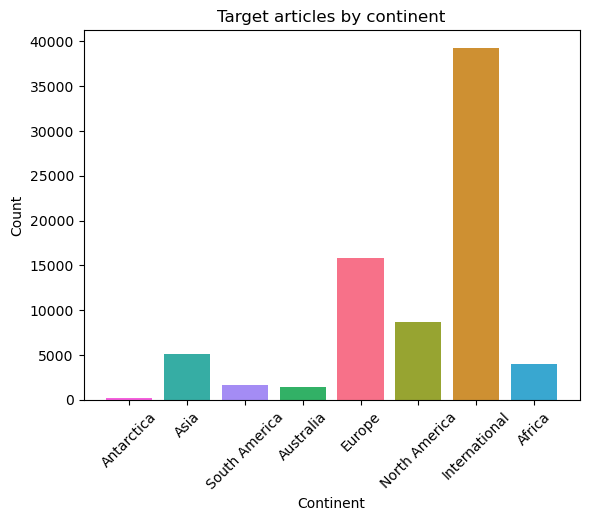

In [38]:
ax = plt.bar(continent_data.index,continent_data['targetArticles'], color=[continents_colors[continent] for continent in continent_data.index])
plt.xticks(rotation=45)

plt.xlabel('Continent')
plt.ylabel('Count')
plt.title('Target articles by continent')
plt.show()

In [39]:
fig = px.bar(
    x=continent_data.index,
    y=continent_data['targetArticles'],
    labels={"x": "Continent", "y": "Count"},
    title="Number of target articles by continent",
    color=[continents_colors_int[continent] for continent in continent_data.index],
    color_discrete_map="identity"
)

fig.update_layout(showlegend=False)

file_path = os.path.join(plots_path, "count_target_articles_by_continent.html")
fig.write_html(file_path)

fig.show()

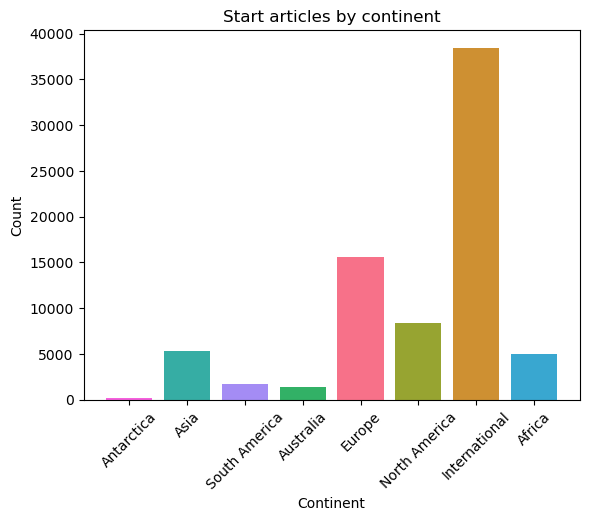

In [40]:
ax = plt.bar(continent_data.index,continent_data['startArticles'], color=[continents_colors[continent] for continent in continent_data.index])
plt.xticks(rotation=45)

plt.xlabel('Continent')
plt.ylabel('Count')
plt.title('Start articles by continent')
plt.show()

In [41]:
fig = px.bar(
    x=continent_data.index,
    y=continent_data['startArticles'],
    labels={"x": "Continent", "y": "Count"},
    title="Number of start articles by continent",
    color=[continents_colors_int[continent] for continent in continent_data.index],
    color_discrete_map="identity"
)

fig.update_layout(showlegend=False)

file_path = os.path.join(plots_path, "count_start_articles_by_continent.html")
fig.write_html(file_path)

fig.show()

In [42]:
df_articles["targetFinished"] = df_articles["article"].map(df_paths_finished["target"].value_counts()).fillna(0)
df_articles["targetUnfinished"] = df_articles["article"].map(df_paths_unfinished["target"].value_counts()).fillna(0)

df_articles["startFinished"] = df_articles["article"].map(df_paths_finished["start"].value_counts()).fillna(0)
df_articles["startUnfinished"] = df_articles["article"].map(df_paths_unfinished["start"].value_counts()).fillna(0)

paths_finished = pd.Series(np.concatenate(df_paths_finished.path.values))
paths_unfinished = pd.Series(np.concatenate(df_paths_unfinished.path.values))

# Create columns to count the number of times each article appears in general in finished and unfinished paths
df_articles["anyFinished"] = df_articles["article"].map(paths_finished.value_counts()).fillna(0)
df_articles["anyUnfinished"] = df_articles["article"].map(paths_unfinished.value_counts()).fillna(0)

# Let's calculate the probability of finding an article (we can compare this with the pagerank)
df_articles["anyPercentage"] = (df_articles["anyFinished"] + df_articles["anyUnfinished"]) / (len(paths_finished) + len(paths_unfinished))

In [43]:
display(df_articles.sort_values("anyPercentage", ascending=False))
print("Size:", df_articles.shape)

,article,category,continent,categoryMain,categoryCounts,length,pageRank,targetFinished,targetUnfinished,startFinished,startUnfinished,anyFinished,anyUnfinished,anyPercentage
1888,United_States,subject.Geography.North_American_Geography,North America,Geography,1084,9731,0.014263,44.0,3.0,44.0,7.0,8896.0,3553.0,0.026149
2044,Europe,subject.Geography.European_Geography,Europe,Geography,1084,4645,0.007043,26.0,2.0,26.0,15.0,4362.0,1249.0,0.011786
1892,United_Kingdom,subject.Geography.Geography_of_Great_Britain,Europe,Geography,1084,9399,0.007679,16.0,0.0,16.0,6.0,3904.0,1424.0,0.011192
2072,England,subject.Geography.Geography_of_Great_Britain,Europe,Geography,1084,8825,0.006815,98.0,14.0,98.0,45.0,3332.0,1226.0,0.009574
419,Earth,subject.Science.Physics.The_Planets,International,Science,1122,5534,0.002298,32.0,0.0,32.0,12.0,3223.0,993.0,0.008856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,Zara_Yaqob,subject.People.Historical_figures,Africa,People,689,1010,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3002,History_of_Solidarity,subject.History.Recent_History,Europe,History,545,4999,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3583,Benjamin_Mountfort,subject.Design_and_Technology.Architecture,Australia,Design_and_Technology,254,2944,0.000041,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3584,Falkirk_Wheel,subject.Design_and_Technology.Engineering,Europe,Design_and_Technology,254,1321,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Size: (4598, 14)


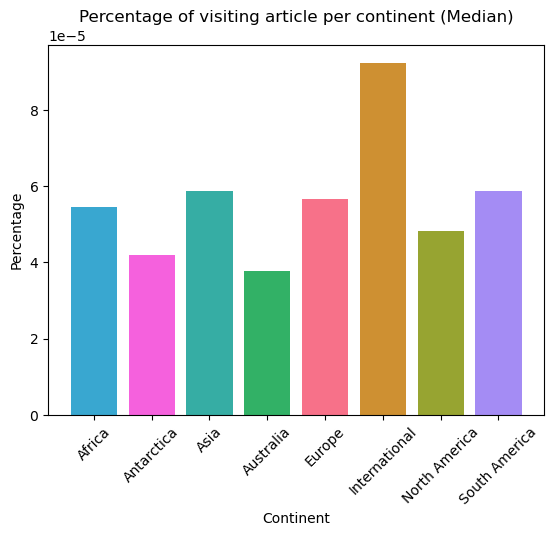

In [44]:
tmp = df_articles.groupby("continent")
tmp = tmp.anyPercentage.median()

ax = plt.bar(tmp.index, tmp, color=[continents_colors[continent] for continent in tmp.index])
plt.xticks(rotation=45)

plt.xlabel('Continent')
plt.ylabel('Percentage')
plt.title('Percentage of visiting article per continent (Median)')
plt.show()

In [45]:
fig = px.bar(
    x=tmp.index,
    y=tmp,
    labels={"x": "Continent", "y": "Percentage"},
    title="Occurrence of article in path",
    color=[continents_colors_int[continent] for continent in tmp.index],
    color_discrete_map="identity"
)

fig.update_layout(showlegend=False)

file_path = os.path.join(plots_path, "article_occurrence_by_continent.html")
fig.write_html(file_path)

fig.show()

# Testing dependance of variables

In [46]:
for col in ["startContinent", "startCategory", "startCategoryMain", "targetContinent", "targetCategory", "targetCategoryMain"]:
    df_analysis[col + "Codes"] = df_analysis[col].astype('category').cat.codes

In [47]:
corr_cols = ["backclicks", "pathSteps", "uniqueArticles", "targetLength", "targetPageRank", "targetContinentCodes", "targetCategoryMainCodes", "startLength", "startPageRank", "startContinentCodes", "startCategoryMainCodes", "isFinished"]
display(df_analysis[corr_cols].corr()["isFinished"])
display(df_analysis[corr_cols].corr("spearman")["isFinished"])


backclicks                -0.034648
pathSteps                  0.143608
uniqueArticles             0.190931
targetLength               0.035084
targetPageRank             0.086476
targetContinentCodes      -0.056026
targetCategoryMainCodes   -0.002181
startLength               -0.000527
startPageRank             -0.000078
startContinentCodes        0.016050
startCategoryMainCodes     0.010104
isFinished                 1.000000
Name: isFinished, dtype: float64

backclicks                -0.041316
pathSteps                  0.305919
uniqueArticles             0.336809
targetLength               0.044579
targetPageRank             0.095765
targetContinentCodes      -0.044511
targetCategoryMainCodes    0.001233
startLength               -0.006699
startPageRank             -0.034686
startContinentCodes        0.004661
startCategoryMainCodes     0.010932
isFinished                 1.000000
Name: isFinished, dtype: float64

In [48]:
sp_lenght = []

with open(os.path.join("Data", "wikispeedia_paths-and-graph", "shortest-path-distance-matrix.txt")) as file:
    for line in file:
        line = line.strip()
        if line == "" or line.startswith("#"):
            continue
    
        sp_lenght.append(list(map(lambda x: -1 if x == "_" else int(x), list(line))))
        
sp_lenght = np.array(sp_lenght)

print(sp_lenght[:10, :10])

[[ 0 -1 -1 -1 -1 -1  3  3  3  3]
 [-1  0 -1 -1 -1 -1  2  2  2  2]
 [-1 -1  0 -1 -1 -1  3  3  2  2]
 [-1 -1 -1  0 -1 -1  3  3  3  3]
 [-1 -1 -1 -1  0 -1  2  2  3  2]
 [-1 -1 -1 -1 -1  0  3  2  2  2]
 [-1 -1 -1 -1 -1 -1  0  1  2  2]
 [-1 -1 -1 -1 -1 -1  1  0  1  1]
 [-1 -1 -1 -1 -1 -1  1  1  0  1]
 [-1 -1 -1 -1 -1 -1  2  2  1  0]]
